In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
# Define directories
train_dir = 'paddy-leaf-disease-main/train'
val_dir = 'paddy-leaf-disease-main/validation'
test_dir = 'paddy-leaf-disease-main/test'

In [4]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    zoom_range=0.5,
    shear_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [5]:
# Load images from directories
training_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_set = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 782 images belonging to 5 classes.
Found 121 images belonging to 5 classes.


In [6]:
# Define the model
base_model = VGG19(input_shape=(256, 256, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

X = Flatten()(base_model.output)
X = Dense(units=len(training_set.class_indices), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=X)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [8]:
# Callbacks
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)
mc = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
callbacks = [es, mc]


In [10]:
# Train the model
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5648 - loss: 7.0960 
Epoch 1: val_accuracy improved from -inf to 0.74380, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 322s 13s/step - accuracy: 0.5671 - loss: 7.0557 - val_accuracy: 0.7438 - val_loss: 5.9157
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7491 - loss: 3.6900
Epoch 2: val_accuracy improved from 0.74380 to 0.76860, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 257s 10s/step - accuracy: 0.7490 - loss: 3.7044 - val_accuracy: 0.7686 - val_loss: 5.7513
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8196 - loss: 2.5623
Epoch 3: val_accuracy improved from 0.76860 to 0.80992, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 248s 10s/step - accuracy: 0.8196 - loss: 2.5677 - val_accuracy: 0.8099 - val_loss: 5.2189
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8009 - loss: 3.3760
Epoch 4: val_accuracy did not improve from 0.80992


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


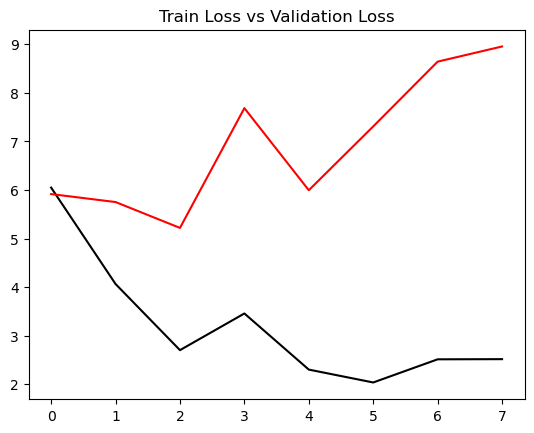

In [11]:
# Plot training history
plt.plot(history.history['loss'], c='black')
plt.plot(history.history['val_loss'], c='red')
plt.title('Train Loss vs Validation Loss')
plt.show()

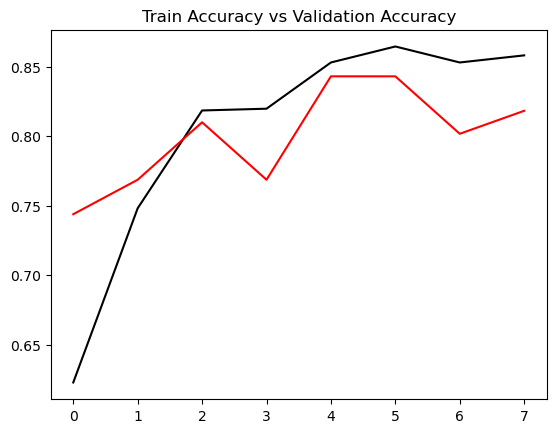

In [12]:
plt.plot(history.history['accuracy'], c='black')
plt.plot(history.history['val_accuracy'], c='red')
plt.title('Train Accuracy vs Validation Accuracy')
plt.show()

In [14]:
loaded_model = tf.keras.models.load_model('best_model.keras')


In [15]:
accuracy = loaded_model.evaluate(test_set)[1]
print(f'Accuracy of validation data is: {round(100*accuracy, 2)} %')


4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - accuracy: 0.8601 - loss: 4.3748
Accuracy of validation data is: 84.3 %


In [20]:
reference = {
    0: 'Brown Spot',
    1: 'Leaf Blast',
    2: 'Leaf Blight',
    3: 'Leaf Smut',
    4: 'Healthy Crop'
}

In [64]:
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input

def prediction(encoded_image):
    # Decode the base64 string
    image_data = base64.b64decode(encoded_image)
    
    # Convert the decoded bytes into a PIL image
    img = Image.open(BytesIO(image_data))
    img = img.convert('RGB')  # Ensure image is in RGB format
    img = img.resize((256, 256))  # Resize image to the required size
    
    # Convert the image to an array
    img_array = img_to_array(img)
    print(f"Image array shape before expand_dims: {img_array.shape}")
    
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    print(f"Image array shape after expand_dims: {img_array.shape}")
    
    img_array = preprocess_input(img_array)  # Preprocess image
    
    # Make prediction using the model
    pred = np.argmax(loaded_model.predict(img_array))
    
    # Retrieve disease info
    disease = reference[pred]
    info = disease_info.get(disease, {
        'description': 'Information not available.',
        'cause': 'Cause not available.',
        'solution': 'Solution not available.',
        'emergency_level': 0
    })
    
    result = {
        'disease': disease,
        'description': info['description'],
        'cause': info['cause'],
        'solution': info['solution'],
        'emergency_level': info['emergency_level']
    }
    
    return result


In [32]:

result = prediction("paddy-leaf-disease-main/validation\Leaf Blight/blight-_0_1753.jpg")
print(f"Disease: {result['disease']}")
print(f"Description: {result['description']}")
print(f"Cause: {result['cause']}")
print(f"Solution: {result['solution']}")
print(f"emergency_level : {result['emergency_level']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
Disease: Leaf Smut
Description: Leaf smut is characterized by dark, smutty spots or lesions on the rice leaves, which can lead to reduced plant health and yield. The lesions are typically irregular and covered with black, spore-filled structures. The disease can weaken the plant, making it more susceptible to other stresses and diseases.
Cause: Leaf smut is caused by the fungal pathogen Entyloma oryzae. The fungus thrives in humid environments and spreads through spores that can be carried by wind and water. Infected plant material and seeds can also be sources of infection.
Solution: Use resistant rice varieties and ensure good field sanitation to remove infected plant debris. Implement proper water management to reduce humidity levels. Fungicide applications can be effective, especially if applied before the disease spreads extensively. Crop rotation can also help manage the disease.
emergency_level : 3


In [30]:
disease_info = {
    'Brown Spot': {
        'description': (
            'Brown spot is a prevalent disease in rice crops characterized by the appearance of '
            'small, round, brown lesions on the leaves. These lesions often have a darker center and '
            'a yellowish halo around them. The disease can significantly reduce the photosynthetic area '
            'of the plant, leading to decreased yield and poor grain quality.'
        ),
        'cause': (
            'Brown spot is caused by the fungal pathogen Bipolaris oryzae, which thrives in warm and '
            'humid conditions. The fungus spreads through infected seeds, plant debris, and water.'
        ),
        'solution': (
            'To manage brown spot, use resistant rice varieties that are less susceptible to the disease. '
            'Ensure proper field drainage to reduce humidity. Practice crop rotation and remove infected '
            'plant debris. Fungicide applications can be effective if applied at the early stages of infection.'
        ),
        'emergency_level': 3  # Moderate danger
    },
    'Leaf Blast': {
        'description': (
            'Leaf blast is a severe disease affecting rice plants, marked by irregularly shaped, water-soaked '
            'lesions on the leaves. These lesions can expand rapidly, causing significant leaf decay and '
            'leading to reduced plant vigor and yield loss. In severe cases, the disease can also affect the '
            'panicles, leading to empty grains.'
        ),
        'cause': (
            'The disease is caused by the fungal pathogen Magnaporthe oryzae. It is highly virulent and spreads '
            'through airborne spores. The fungus infects plants during periods of high humidity and warm temperatures.'
        ),
        'solution': (
            'Plant resistant or tolerant rice varieties and apply balanced fertilization to strengthen plant health. '
            'Use proper water management practices, such as maintaining intermittent flooding. Fungicides can be used '
            'during the early stages of the disease. Regular monitoring and timely intervention are crucial for control.'
        ),
        'emergency_level': 4  # High danger
    },
    'Leaf Blight': {
        'description': (
            'Leaf blight is a disease that manifests as dark, water-soaked lesions on the rice leaves, which eventually '
            'turn necrotic. The blight reduces the photosynthetic capacity of the plant, leading to poor growth and reduced '
            'grain yield. Infected leaves may dry out prematurely, affecting the overall health of the plant.'
        ),
        'cause': (
            'The disease is caused by the bacterial pathogen Xanthomonas oryzae pv. oryzae. It spreads through infected '
            'seeds, plant residues, and water. High humidity and warm temperatures favor the development of this disease.'
        ),
        'solution': (
            'To control leaf blight, use disease-resistant rice varieties and practice crop rotation. Avoid overhead irrigation '
            'to reduce leaf wetness. Apply copper-based fungicides or bactericides if the disease is detected early. Proper field '
            'sanitation and management practices are essential to prevent outbreaks.'
        ),
        'emergency_level': 4  # High danger
    },
    'Leaf Smut': {
        'description': (
            'Leaf smut is characterized by dark, smutty spots or lesions on the rice leaves, which can lead to reduced plant '
            'health and yield. The lesions are typically irregular and covered with black, spore-filled structures. The disease '
            'can weaken the plant, making it more susceptible to other stresses and diseases.'
        ),
        'cause': (
            'Leaf smut is caused by the fungal pathogen Entyloma oryzae. The fungus thrives in humid environments and spreads '
            'through spores that can be carried by wind and water. Infected plant material and seeds can also be sources of '
            'infection.'
        ),
        'solution': (
            'Use resistant rice varieties and ensure good field sanitation to remove infected plant debris. Implement proper water '
            'management to reduce humidity levels. Fungicide applications can be effective, especially if applied before the disease '
            'spreads extensively. Crop rotation can also help manage the disease.'
        ),
        'emergency_level': 3  # Moderate danger
    },
    'Healthy Crop': {
        'description': (
            'The plant is in a healthy state, exhibiting normal growth and development. The leaves are vibrant, green, and free of '
            'any visible symptoms of disease or stress. The plant shows good vigor and is expected to yield well under standard growing conditions.'
        ),
        'cause': (
            'The plant is not affected by any disease or stress. It is receiving adequate nutrients, water, and care, contributing to its optimal health.'
        ),
        'solution': (
            'Continue with regular crop management practices, including proper watering, fertilization, and pest control. Maintain good field hygiene and monitor the plants regularly to ensure they remain healthy.'
        ),
        'emergency_level': 0  # No danger
    }
}


In [33]:
pip install modelbit

In [35]:
import modelbit
mb = modelbit.login()

In [37]:

def encode_image_to_base64(file_path):
    # Open the image file
    with open(file_path, "rb") as image_file:
        # Read the image data
        image_data = image_file.read()
        
        # Encode the image data to base64
        encoded_image = base64.b64encode(image_data).decode('utf-8')
        
    return encoded_image

In [46]:
encoded_image_test = encode_image_to_base64("paddy-leaf-disease-main/test/Brown Spot/brown_spot_01.PNG")

In [65]:
mb.deploy(prediction)

In [66]:
modelbit.get_inference(
  region="us-east-1",
  workspace="sabarikrishnan",
  deployment="prediction",
  data=encoded_image_test
)



{'data': {'disease': 'Brown Spot',
  'description': 'Brown spot is a prevalent disease in rice crops characterized by the appearance of small, round, brown lesions on the leaves. These lesions often have a darker center and a yellowish halo around them. The disease can significantly reduce the photosynthetic area of the plant, leading to decreased yield and poor grain quality.',
  'cause': 'Brown spot is caused by the fungal pathogen Bipolaris oryzae, which thrives in warm and humid conditions. The fungus spreads through infected seeds, plant debris, and water.',
  'solution': 'To manage brown spot, use resistant rice varieties that are less susceptible to the disease. Ensure proper field drainage to reduce humidity. Practice crop rotation and remove infected plant debris. Fungicide applications can be effective if applied at the early stages of infection.',
  'emergency_level': 3}}